# Проект `Movie by frame`

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import zipfile
import os
import re
import shutil
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from timm import create_model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Функция фиксирует seed для корректного сравнения оптимизаторов
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(13)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

## Разделение данных на обучающие и валидационные датасеты

Для подготовки данных к обучению выполним ряд шагов для каждого датасета:
- Распаковка архива с кадрами к фильмам
- Создание папок для хранения данных для `train` и `val`
- Переименование кадров к фильмам (для удобства)
- Разделение выборки через `train_test_split`
- Перенос данных по нужным папкам

In [ ]:
# Функция для распаковки архива и создания доп.папки
def unzip_and_create_dir(filename):
    zip_filepath = os.path.join(zip_dir, filename)
    dataset_name = os.path.splitext(filename)[0]
    unpack_dir = os.path.join("/content", dataset_name)
    os.makedirs(unpack_dir, exist_ok=True)

    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(unpack_dir)

    split_dir = os.path.join("/content", dataset_name + "_split")
    os.makedirs(split_dir, exist_ok=True)
    os.makedirs(os.path.join(split_dir, "train"), exist_ok=True)
    os.makedirs(os.path.join(split_dir, "val"), exist_ok=True)
    return unpack_dir, split_dir


In [ ]:
# Переименование имён файлов для удобства
def rename_frames(movie_path):
    frames = [os.path.join(movie_path, f) for f in os.listdir(movie_path)]
    for i, frame in enumerate(frames):
        ext = os.path.splitext(frame)[-1]
        new_name = f"{i + 1:04d}{ext}"
        old_path = os.path.join(movie_path, frame)
        new_path = os.path.join(movie_path, new_name)
        os.rename(old_path, new_path)


In [ ]:
# Функция для перемещения кадров с фильмами по папкам train и val
def move_files(X_split, y_split, split_dir):
    for file_path, label in zip(X_split, y_split):
        target_dir = os.path.join(split_dir, label)
        os.makedirs(target_dir, exist_ok=True)
        shutil.move(file_path, os.path.join(target_dir, os.path.basename(file_path)))


In [ ]:
# Функция для разделения датасета
def split_dataset(movie_path, split_dir):
    X, y = [], []
    frames = [os.path.join(movie_path, f) for f in os.listdir(movie_path)]
    X.extend(frames)
    y.extend([movie] * len(frames))

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
    move_files(X_train, y_train, split_dir + "/train")
    move_files(X_val, y_val, split_dir + "/val")


In [ ]:
zip_dir = "/content/drive/MyDrive/datasets"
zip_pattern = re.compile(r"^movies.*\.zip$")

for filename in os.listdir(zip_dir):
    if not zip_pattern.match(filename): continue

    unpack_dir, split_dir = unzip_and_create_dir(filename)
    for movie in os.listdir(unpack_dir):
        movie_path = os.path.join(unpack_dir, movie)
        rename_frames(movie_path)
        split_dataset(movie_path, split_dir)

    shutil.rmtree(unpack_dir)


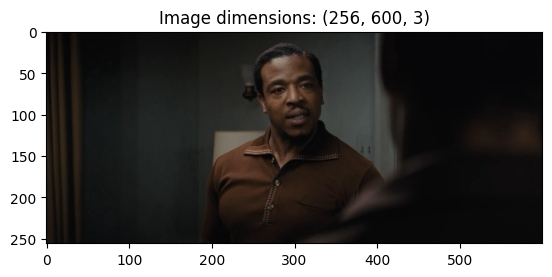

In [ ]:
def show_image_dimensions(image_path):
    img = mpimg.imread(image_path)
    plt.title(f"Image dimensions: {img.shape}")
    plt.imshow(img)
    plt.show()


random_movie = random.choice(os.listdir(os.path.join(split_dir, "val")))
random_frame = random.choice(os.listdir(os.path.join(split_dir, "val", random_movie)))
image_path = os.path.join(split_dir, "val", random_movie, random_frame)

show_image_dimensions(image_path)

## Создание даталоадеров для обучения и валидации

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
datasets, dataloaders = {}, {}
movie_dir_pattern = re.compile(r"^movies.*_split$")
BATCH_SIZE = 64

for cur_dir in sorted(os.listdir("/content")):
    if not movie_dir_pattern.match(cur_dir): continue

    abs_dir_path = os.path.join("/content", cur_dir)
    datasets[abs_dir_path], dataloaders[abs_dir_path] = {}, {}
    train_dataset = ImageFolder(abs_dir_path + "/train", transform=train_transform)
    val_dataset = ImageFolder(abs_dir_path + "/val", transform=val_transform)

    datasets[abs_dir_path]["train"] = train_dataset
    datasets[abs_dir_path]["val"] = val_dataset

    dataloaders[abs_dir_path]["train"] = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    dataloaders[abs_dir_path]["val"] = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


next(iter(datasets.values()))["val"].class_to_idx


{'1917 (2019)': 0,
 'An Education (2009)': 1,
 'Baby Driver (2017)': 2,
 'Before Midnight (2013)': 3,
 'Before Sunrise (1995)': 4,
 'Before Sunset (2004)': 5,
 'Blade Runner 2049 (2017)': 6,
 'Braveheart (1995)': 7,
 'Cruella (2021)': 8,
 'Doctor Strange (2016)': 9,
 'Doctor Strange In The Multiverse Of Madness (2022)': 10,
 'Dunkirk (2017)': 11,
 'Eyes Wide Shut (1999)': 12,
 'Fear And Loathing In Las Vegas (1998)': 13,
 'Fences (2016)': 14,
 'First Man (2018)': 15,
 'Friday (1995)': 16,
 'Good Time (2017)': 17,
 'Good Will Hunting (1997)': 18,
 'Heat (1995)': 19,
 'Hot Fuzz (2007)': 20,
 'John Wick (2014)': 21,
 'Kingdom Of Heaven (2005)': 22,
 'Lucky Number Slevin (2006)': 23,
 'Man On The Moon (1999)': 24,
 'Man of Steel (2013)': 25,
 'Match Point (2005)': 26,
 'Michael Clayton (2007)': 27,
 'Midnight In Paris (2011)': 28,
 'No Time To Die (2021)': 29,
 'Platoon (1986)': 30,
 'Pleasantville (1998)': 31,
 'Point Break (1991)': 32,
 'Rocketman (2019)': 33,
 'Skyfall (2012)': 34,
 'Sl

In [ ]:
!mkdir /content/drive/MyDrive/class_mappings
for k, v in datasets.items():
    name = "classes_" + "_".join(k.split("/")[-1].split("_")[:2]) + ".txt"
    with open(name, "w") as file:
        for i, class_name in enumerate(v["val"].classes):
            file.write(f"{class_name}: {i}\n")

    print(f"Saved {name}")
    !cp $name /content/drive/MyDrive/class_mappings


Saved classes_movies_50.txt
Saved classes_movies_5.txt
Saved classes_movies_all.txt


## Тренировка и валидация моделей

In [ ]:
import wandb

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lolbl4 (lolbl4-hse) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
%pip install pytorch-lightning

In [ ]:
import pytorch_lightning as pl

class ViTClassifier(pl.LightningModule):

    def __init__(self, *, model_name, num_classes, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model = create_model(model_name, pretrained=True, num_classes=num_classes)
        self.model.head = nn.Linear(self.model.head.in_features, num_classes)

        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        self.log("train_loss", loss, prog_bar=True, on_epoch=True, logger=True)
        self.log("train_acc", acc, prog_bar=True, on_epoch=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.criterion(outputs, labels)
        acc = (outputs.argmax(dim=1) == labels).float().mean()

        self.log("val_loss", loss, prog_bar=True, on_epoch=True, logger=True)
        self.log("val_acc", acc, prog_bar=True, on_epoch=True, logger=True)

        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return [optimizer], [scheduler]


In [ ]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import logging


logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
epochs = 10

def train_model(model_size, dataset_path):
    seed_everything(13)
    data = dataloaders[dataset_path]
    print(f"Training {model_size} on dataset: {dataset_path}")

    # Подготовка wandb для отслеживания метрик и обучения
    model_pref = "-".join(model_size.split("_")[:2])
    dataset_suff = dataset_path.split("/")[-1].replace("_split", "")
    wandb_run_name = f"{model_pref}-{dataset_suff}".replace("_", "-")
    wandb_logger = WandbLogger(log_model='all', project="movie-by-frame", name=wandb_run_name)

    # Создание модели
    num_classes = len(datasets[dataset_path]["val"].classes)
    model = ViTClassifier(model_name=model_size, num_classes=num_classes)

    # Создание checkpoint для отслеживания лучших метрик
    checkpoint_callback = ModelCheckpoint(
        monitor="val_acc", mode="max",
        save_top_k=1, filename=f"{wandb_run_name}-best",
        save_last=True
    )

    # Обучение модели
    trainer = pl.Trainer(max_epochs=epochs, accelerator=device,
                        logger=wandb_logger, enable_model_summary=False,
                        callbacks=[checkpoint_callback], log_every_n_steps=15)
    trainer.fit(model, data["train"], data["val"])

    best_model_path = checkpoint_callback.best_model_path
    best_model = ViTClassifier.load_from_checkpoint(best_model_path)

    # Вывод результатов валидации и сохранение весов лучшей модели
    val_result = trainer.validate(best_model, data["val"])
    print(val_result)
    model_weights_path = f"/content/drive/MyDrive/weights/{wandb_run_name}-best-weights.pt"
    torch.save(best_model.state_dict(), model_weights_path)

    wandb.finish()


### ViT

Про ViT можно почитать [здесь](https://huggingface.co/google/vit-base-patch16-224)

In [ ]:
it = iter(dataloaders.keys())

In [ ]:
train_model("vit_base_patch16_224", next(it))

Training vit_base_patch16_224 on dataset: /content/movies_50_processed_split


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.8962357044219971     │
│         val_loss          │    0.3620889186859131     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.3620889186859131, 'val_acc': 0.8962357044219971}]


epoch,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
train_acc_epoch,▁▅▆▇▇█████
train_acc_step,▁▂▃▃▃▄▅▆▆▆▇▆▇▆▆▇▇▇▇▇▆█▇███▇██████████▇██
train_loss_epoch,█▄▃▂▂▁▁▁▁▁
train_loss_step,█▆▆▅▅▃▄▃▃▃▃▂▂▃▂▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
val_acc,▁▄▅▆▆██████
val_loss,█▅▃▃▃▁▁▁▂▁▁
epoch,10
train_acc_epoch,0.96524
train_acc_step,1


In [ ]:
train_model("vit_base_patch16_224", next(it))

Training vit_base_patch16_224 on dataset: /content/movies_5_processed_split


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9209486246109009     │
│         val_loss          │    0.25935012102127075    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.25935012102127075, 'val_acc': 0.9209486246109009}]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
train_acc_epoch,▁▅▇▇▇█████
train_acc_step,▁▂▆▅▆▆██▇█
train_loss_epoch,█▄▃▂▂▁▁▁▁▁
train_loss_step,█▆▂▄▂▃▁▂▂▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
val_acc,▁▄▅▄██▇▇███
val_loss,█▄▄▅▁▁▃▂▁▁▁
epoch,10
train_acc_epoch,0.97319
train_acc_step,0.98438


In [ ]:
train_model("vit_base_patch16_224", next(it))

Training vit_base_patch16_224 on dataset: /content/movies_all_processed_split


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.86247318983078      │
│         val_loss          │    0.5355943441390991     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5355943441390991, 'val_acc': 0.86247318983078}]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅█
train_acc_epoch,█▁
train_acc_step,▄█▇█▇▇█▇█▄▇███▇▅██▅█▇██▇▅█▅▄▅▅▅█▄█▁██▇▅▂
train_loss_epoch,▁█
train_loss_step,█▆▂▂▆▅▁▂▁▃▄▂▂▁▂▃▁▅▃▃▆▂▄▂▂▃▅▂▄▃▄▂▆▂▄▄▂▄▃▅
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
val_acc,█▁█
val_loss,▁█▁
epoch,10
train_acc_epoch,0.9789
train_acc_step,0.9375


### DeiT

Про DeiT можно почитать [здесь](https://huggingface.co/facebook/deit-base-patch16-224)

In [ ]:
it = iter(dataloaders.keys())

In [ ]:
train_model("deit_base_patch16_224", next(it))

Training deit_base_patch16_224 on dataset: /content/movies_50_processed_split


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9270049333572388     │
│         val_loss          │    0.2558651864528656     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.2558651864528656, 'val_acc': 0.9270049333572388}]


epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█
train_acc_epoch,▁▆▇▇▇█████
train_acc_step,▂▁▃▄▃▅▆▆▅▆▆▇▇▇█▇▇▇▇▇▇▇▇▇██▇▇▇██▇████████
train_loss_epoch,█▃▂▂▁▁▁▁▁▁
train_loss_step,█▆▄▃▄▃▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_acc,▁▅▅▆▇██████
val_loss,█▄▃▂▂▁▁▁▁▁▁
epoch,10
train_acc_epoch,0.9754
train_acc_step,0.98438


In [ ]:
train_model("deit_base_patch16_224", next(it))

Training deit_base_patch16_224 on dataset: /content/movies_5_processed_split


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.95652174949646      │
│         val_loss          │    0.14537766575813293    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.14537766575813293, 'val_acc': 0.95652174949646}]


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
train_acc_epoch,▁▇▇▇██████
train_acc_step,▁▅▆▆▆▆██▇▇
train_loss_epoch,█▃▂▂▂▁▁▁▁▁
train_loss_step,█▄▂▂▂▂▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
val_acc,▁▂▅▅▅▇▇▆█▇█
val_loss,█▆▄▃▃▂▃▂▁▁▁
epoch,10
train_acc_epoch,0.99007
train_acc_step,0.98438


In [ ]:
train_model("deit_base_patch16_224", next(it))

Training deit_base_patch16_224 on dataset: /content/movies_all_processed_split


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9722668528556824     │
│         val_loss          │    0.11617544293403625    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.11617544293403625, 'val_acc': 0.9722668528556824}]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█
train_acc_epoch,▁
train_acc_step,▆▅▅▆▅▁▂▆▆▅▅▇▅▄▆▂▆▃▆▆▅█▅▅▅▇▅▆▄▅▇▅▆█▅▅▆▆▃▆
train_loss_epoch,▁
train_loss_step,▄▅▄▃▃▃▂█▅▅▂▄▅▆▃▅▂▅▂▃▂▃▃▂▆▂▁▆▂▆▂▃▄▂▄▃▃▃▄▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
val_acc,▁▁
val_loss,▁▁
epoch,10
train_acc_epoch,0.93575
train_acc_step,0.95312


## Выводы и таблица с метриками

| Модели               | 5 фильмов   | 50 фильмов  | 250+ фильмов |
|----------------------|-------------|-------------|--------------|
| vit-base-patch16-224 | `0.9209`    | `0.8962`    | `0.8625`     |
| deit-base-patch16-224  | `0.9565`    | `0.9270`    | `0.9722`     |

Все графики по [ссылке](https://wandb.ai/lolbl4-hse/movie-by-frame/table?nw=nwuserlolbl4)
